<a href="https://colab.research.google.com/github/CoderAPS/neural_nets/blob/main/image_segmentation3(20230426_v6_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output


import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow import keras
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tqdm.notebook import tqdm_notebook

%matplotlib inline 

In [4]:
# import segmentation models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
from segmentation_models.utils import set_trainable

Segmentation Models: using `tf.keras` framework.


In [5]:
tf.__version__

'2.12.0'

In [6]:
!python --version

Python 3.10.11


In [ ]:
# https://github.com/tensorflow/addons#python-op-compatibility-matrix
#pip install tensorflow-addons-0.20.0

In [ ]:
#import tensorflow_addons as tfa

In [ ]:
# split dataset into 85% train, 10% validation and 5% test
# during training create a validation set from training set
dataset,info = tfds.load('oxford_iiit_pet:3.*.*', 
                                split=['train+test[:70%]',
                                       'test[70%:90%]',
                                       'test[90%:]'],
                                with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [8]:
print(f'Number of images/masks in train set: {len(dataset[0])}')
print(f'Number of images/masks in validation set: {len(dataset[1])}')
print(f'Number of images/masks in test set: {len(dataset[2])}')

Number of images/masks in train set: 6248
Number of images/masks in validation set: 734
Number of images/masks in test set: 367


In [9]:
img_height = 128
img_width = 128
n_classes = 3

In [10]:
# Function to resize images and segmentation masks
# subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2} from {1,2,3}
def resize_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (img_height, img_width))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (img_height, img_width),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_mask -= 1

  return input_image, input_mask

In [11]:
train_dataset = dataset[0].map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = dataset[1].map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
train_dataset

<_ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>

In [13]:
# Creat train numpy arrays for X and y
# Transfer images, masks into numpy arrays
# By converting PrefetchDataset(dataset[0],dataset[1],dataset[2]) into numpy
# and then them to respective list
# Exclude images and masks where the mask does not have all 3 values

# Allocate memory for numpy arrays
# train images
X_train = np.zeros(shape=(6236,128,128,3)) 
# train masks
Y_train = np.zeros(shape=(6236,128,128,1))

idx = 0
counter = 0
for img,mask in tqdm_notebook(train_dataset.take(6248),total=6248):
    if len(np.unique(mask.numpy())) == 3: 
      X_train[idx] = img
      Y_train[idx] = mask
      idx += 1
    else:
      counter += 1

print (f'Completed transfer of: {len(X_train)} images and masks.')
print(f'Number of faulty masks: {counter}.')

  0%|          | 0/6248 [00:00<?, ?it/s]

Completed transfer of: 6236 images and masks.
Number of faulty masks: 12.


In [14]:
# Creat val numpy arrays for X and y
# Transfer images, masks into numpy arrays
# By converting PrefetchDataset(dataset[0],dataset[1],dataset[2]) into numpy
# and then them to respective list

# Allocate memory for numpy arrays
# val images
X_val = np.zeros(shape=(733,128,128,3)) 
# val masks
Y_val = np.zeros(shape=(733,128,128,1))

i = 0
counter = 0
for img,mask in tqdm_notebook(val_dataset.take(734),total=734):
  if len(np.unique(mask.numpy())) == 3: 
    X_val[i] = img
    Y_val[i] = mask
    i += 1
  else:
    counter += 1

print (f'Completed transfer of: {len(X_val)} images and masks.')
print(f'Number of faulty masks: {counter}.')

  0%|          | 0/734 [00:00<?, ?it/s]

Completed transfer of: 733 images and masks.
Number of faulty masks: 1.


In [15]:
# Display image, repective mask and model prediction 
def display(data_list,divide=255):
  plt.figure(figsize=(12,8))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(data_list)):
    plt.subplot(1, len(data_list), i+1)
    plt.title(title[i])
    plt.imshow(data_list[i]/divide)
    plt.axis('off')
  plt.show()


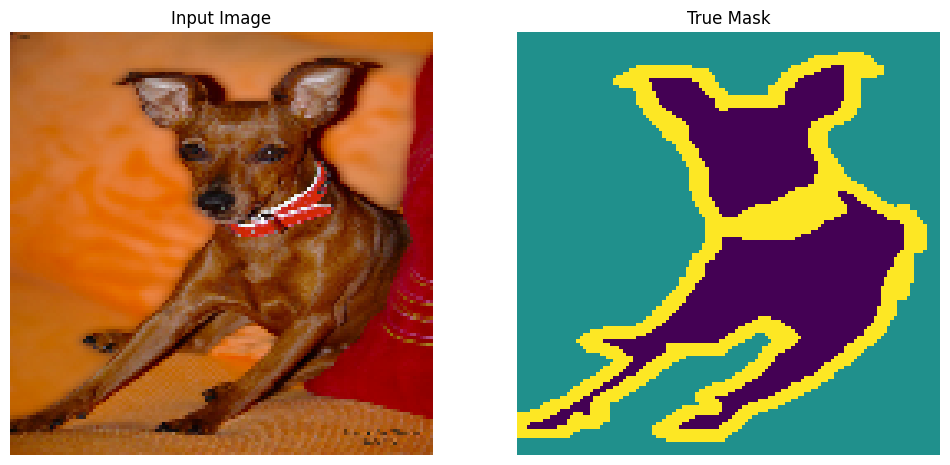

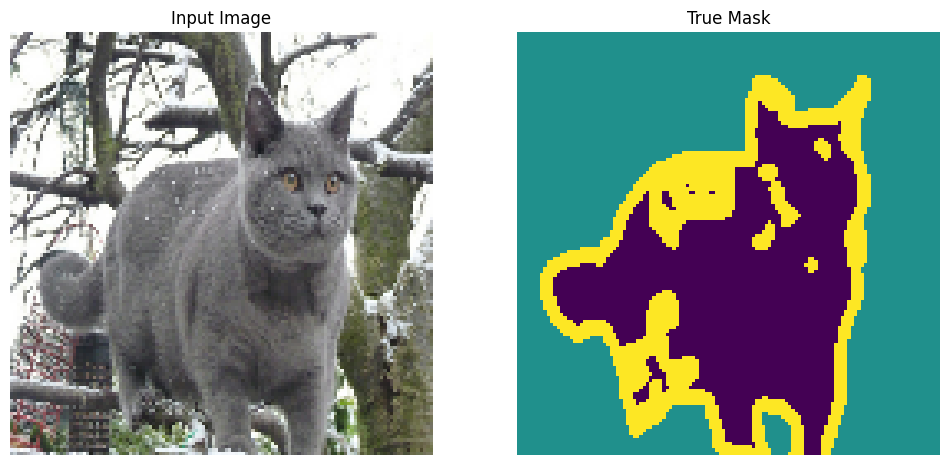

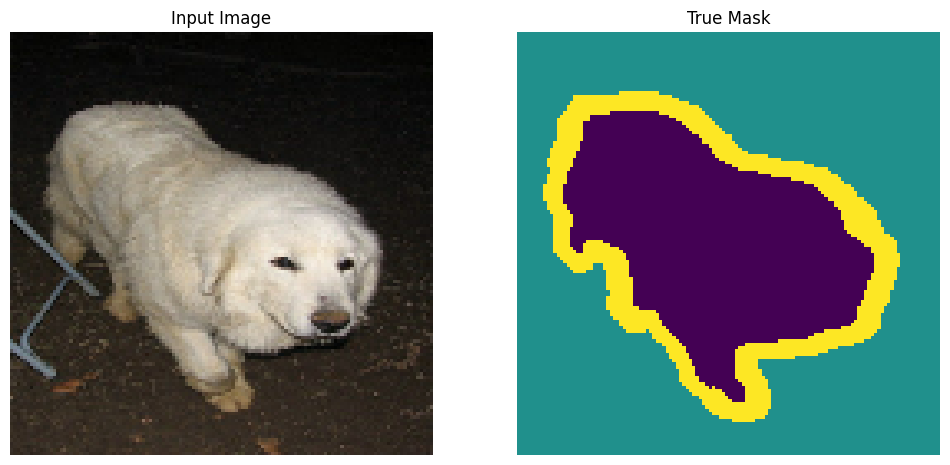

In [16]:
# Randomly select an image and its respective mask 3 times for display
for i in range(3):
  num = np.random.randint(0,3000)
  display([X_train[num],Y_train[num]])

In [17]:
print(f'Shape of X_train: {X_train.shape}\tData type: {type(X_train)}')
print(f'Shape of Y_train: {Y_train.shape}\tData type: {type(Y_train)}')
print(f'Shape of X_val: {X_val.shape}\tData type: {type(X_val)}')
print(f'Shape of Y_val: {Y_val.shape}\tData type: {type(Y_val)}')

Shape of X_train: (6236, 128, 128, 3)	Data type: <class 'numpy.ndarray'>
Shape of Y_train: (6236, 128, 128, 1)	Data type: <class 'numpy.ndarray'>
Shape of X_val: (733, 128, 128, 3)	Data type: <class 'numpy.ndarray'>
Shape of Y_val: (733, 128, 128, 1)	Data type: <class 'numpy.ndarray'>


In [18]:
# Convert masks/labels to categorical (onehot encode)
Y_train_cat = to_categorical(Y_train,num_classes=3)
Y_val_cat = to_categorical(Y_val, num_classes=3)

In [19]:
print(f'Y_train_cat.shape: {Y_train_cat.shape}')
print(f'Y_val_cat.shape: {Y_val_cat.shape}')

Y_train_cat.shape: (6236, 128, 128, 3)
Y_val_cat.shape: (733, 128, 128, 3)


In [20]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]

  return pred_mask[0]

In [21]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = current_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)],divide=1)
  else:
    display([sample_image, sample_mask,
             create_mask(current_model.predict(sample_image[tf.newaxis, ...]))],divide=1)

In [22]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [23]:
def show_history(model_history):
  print(f'{model_history.history.keys()}')

  var = list(model_history.history.keys())
  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']

  mean_iou = model_history.history[var[1]]
  val_mean_iou = model_history.history[var[-2]]
  
  learning_rate = model_history.history[var[-1]]

  epochs_range = model_history.epoch

  plt.figure(figsize=(14, 6))
  plt.subplot(1, 3, 1)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')


  plt.subplot(1, 3, 2)
  plt.plot(epochs_range, mean_iou, label='Training MeanIoU')
  plt.plot(epochs_range, val_mean_iou, label='Validation MeanIoU')
  plt.legend(loc='lower right')
  plt.title('Training and Validation IoU')

  plt.subplot(1,3,3)
  plt.plot(epochs_range,learning_rate,label='Learning Rate')
  plt.legend(loc='upper right')
  plt.title('Learning Rate')
  plt.show()

  
  train_loss = model_history.history['loss'][-1]
  val_loss = model_history.history['val_loss'][-1]
  train_meanIoU = model_history.history[var[1]][-1]
  val_meanIoU = model_history.history[var[-2]][-1]

  print(f'Training loss: {train_loss:.3f}\tTraining meanIoU: {train_meanIoU:.3f}')
  print(f'Validation loss: {val_loss:.3f}\tValidation meanIoU: {val_meanIoU:.3f}')
  


In [24]:
earlystopper = EarlyStopping(patience=3, verbose=1)
callback_list = [earlystopper,DisplayCallback()]

In [25]:
BACKBONE = 'resnet18'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_p = preprocess_input(X_train.copy())
X_val_p = preprocess_input(X_val.copy())

In [26]:
p_max = X_train_p[1].max()
p_min = X_train_p[1].min()
p_mean = X_train_p[1].mean()
p_median = np.percentile(X_train_p[1],50)
print(f'Mean: {p_mean}\tMedian: {p_median}')
print(f'Min.: {p_min}\t\t\tMax.: {p_max}')

Mean: 98.12961354975899	Median: 83.94992065429688
Min.: 0.0			Max.: 255.0


Image number: 3262


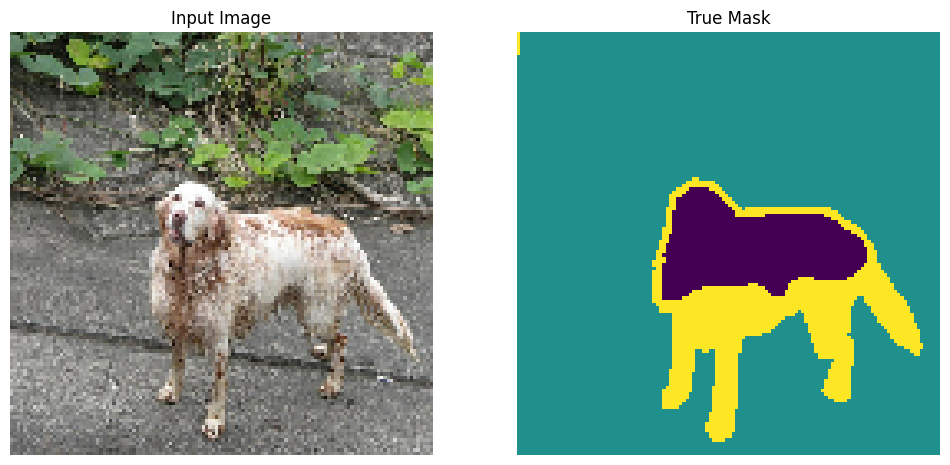

In [27]:
img_num = np.random.randint(0,len(X_train_p))
print(f'Image number: {img_num}')
sample_image, sample_mask = X_train_p[img_num],Y_train[img_num]
display([sample_image,sample_mask])

In [ ]:
# define model
activation='softmax'

model_2a = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                activation=activation,classes=n_classes,
                input_shape=(img_height,img_width,3),
                encoder_freeze=True)

current_model = model_2a

44920640/44920640 [==============================] - 2s 0us/step


1/1 [==============================] - 8s 8s/step


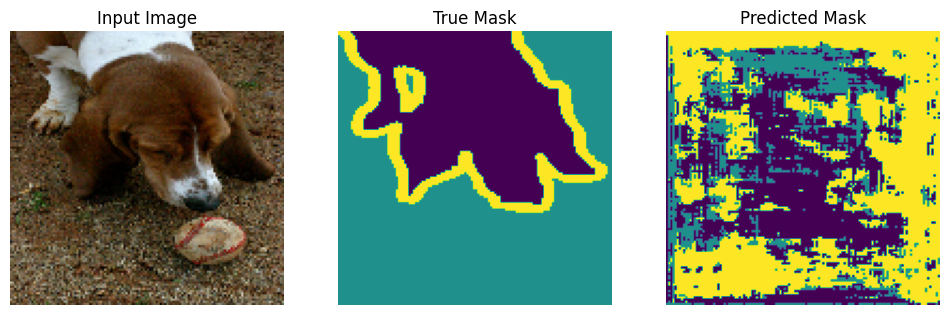

In [ ]:
show_predictions()

In [ ]:
LR = 0.0001
optimizer_input_2a = keras.optimizers.Adam(LR)
loss_input_2a = sm.losses.JaccardLoss()
metrics_input_2a = [tf.keras.metrics.MeanIoU(num_classes=3,
                                             sparse_y_pred = False,
                                             sparse_y_true=False)]

In [ ]:
model_2a.compile(optimizer=optimizer_input_2a,
              loss=loss_input_2a,
              metrics=metrics_input_2a)

In [ ]:
#model_2a.summary()

In [ ]:
#tf.keras.utils.plot_model(model_2a, show_shapes=True)
len(model_2a.layers)

127

1/1 [==============================] - 0s 21ms/step


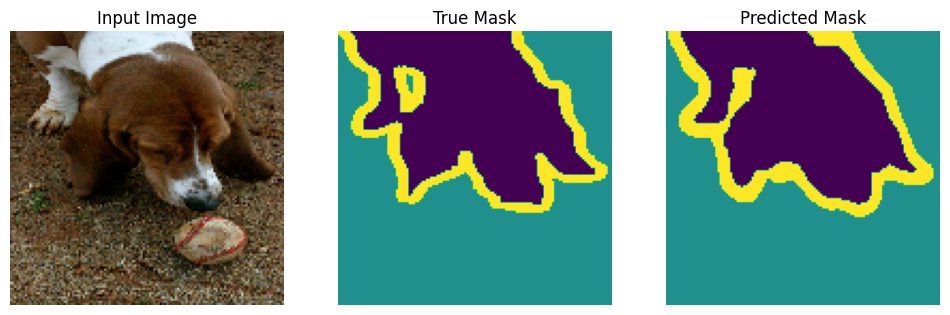


Sample Prediction after epoch 32

250/250 [==============================] - 23s 90ms/step - loss: 0.1554 - mean_io_u: 0.8455 - val_loss: 0.2325 - val_mean_io_u: 0.7682
Epoch 32: early stopping


In [ ]:
# Pre-train model
history_2a =model_2a.fit(X_train_p, 
            Y_train_cat,
            batch_size=25, 
            epochs=50,
            verbose=1,
            validation_data=(X_val_p,Y_val_cat),
            callbacks=callback_list)

In [ ]:
# Allow model to train on data
model_2a.trainable = True

In [ ]:
#model_2a.summary()

1/1 [==============================] - 0s 20ms/step


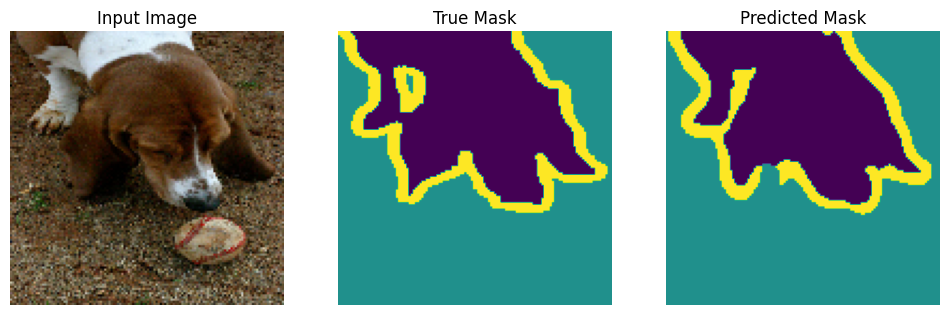


Sample Prediction after epoch 7

250/250 [==============================] - 23s 90ms/step - loss: 0.1462 - mean_io_u: 0.8546 - val_loss: 0.2338 - val_mean_io_u: 0.7668
Epoch 7: early stopping


In [ ]:
# Fine tune model
history_2a =model_2a.fit(X_train_p, 
            Y_train_cat,
            batch_size=25, 
            epochs=50,
            verbose=1,
            validation_data=(X_val_p,Y_val_cat),
            callbacks=callback_list)

dict_keys(['loss', 'mean_io_u', 'val_loss', 'val_mean_io_u'])


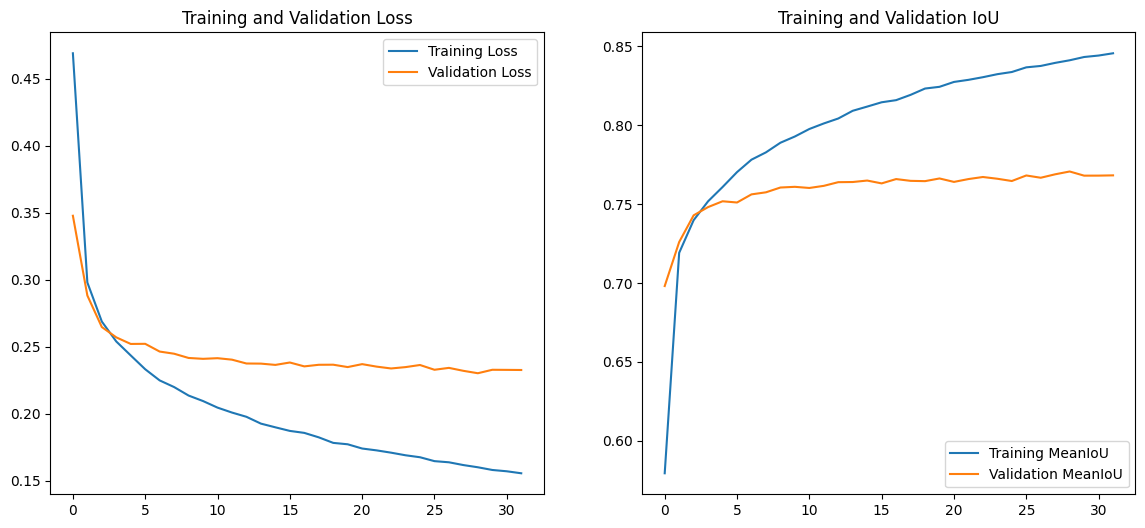

Training loss: 0.155	Training meanIoU: 0.845
Validation loss: 0.233	Validation meanIoU: 0.768


In [ ]:
show_history(history_2a)

In [ ]:
BACKBONE = 'resnet152'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_p = preprocess_input(X_train.copy())
X_val_p = preprocess_input(X_val.copy())

In [ ]:
# define model
activation='softmax'

model_3a = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                activation=activation,classes=n_classes,
                input_shape=(img_height,img_width,3),
                encoder_freeze=True)

current_model = model_3a

234326024/234326024 [==============================] - 6s 0us/step


1/1 [==============================] - 4s 4s/step


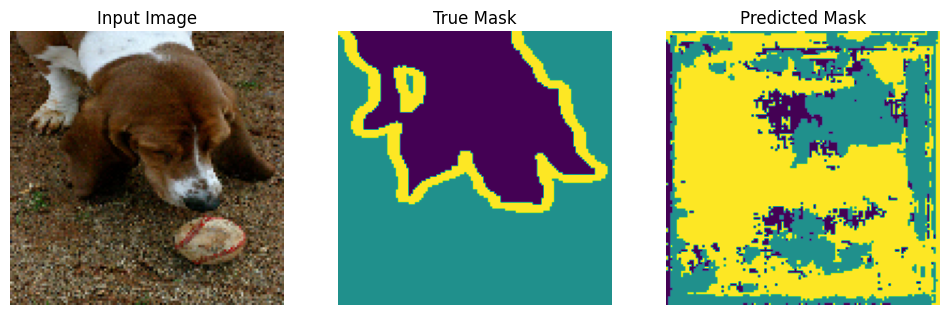

In [ ]:
show_predictions()

In [ ]:
#tf.keras.utils.plot_model(model_2a, show_shapes=True)
len(model_3a.layers)

605

In [ ]:
LR = 0.0001
optimizer_input_3a = keras.optimizers.Adam(LR)
loss_input_3a = sm.losses.JaccardLoss()
metrics_input_3a = [tf.keras.metrics.MeanIoU(num_classes=3,
                                             sparse_y_pred = False,
                                             sparse_y_true=False)]

In [ ]:
model_3a.compile(optimizer=optimizer_input_3a,
              loss=loss_input_3a,
              metrics=metrics_input_3a)

1/1 [==============================] - 0s 30ms/step


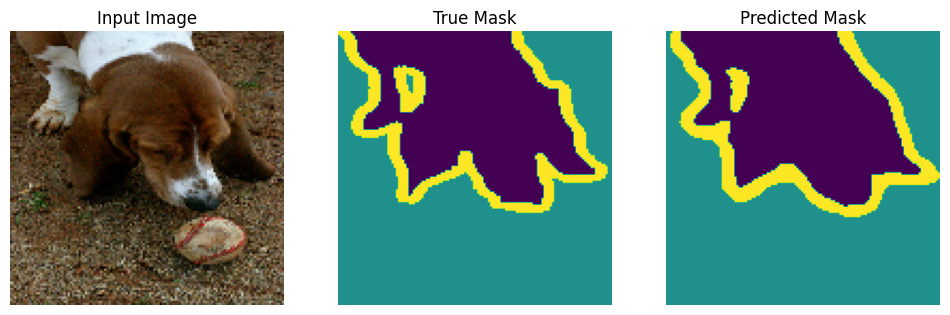


Sample Prediction after epoch 17

250/250 [==============================] - 64s 255ms/step - loss: 0.1581 - mean_io_u_1: 0.8432 - val_loss: 0.2170 - val_mean_io_u_1: 0.7840
Epoch 17: early stopping


In [ ]:
# Pre-train model
history_3a =model_3a.fit(X_train_p, 
            Y_train_cat,
            batch_size=25, 
            epochs=50,
            verbose=1,
            validation_data=(X_val_p,Y_val_cat),
            callbacks=callback_list)

In [ ]:
# Allow model to train on data
model_3a.trainable = True

1/1 [==============================] - 0s 35ms/step


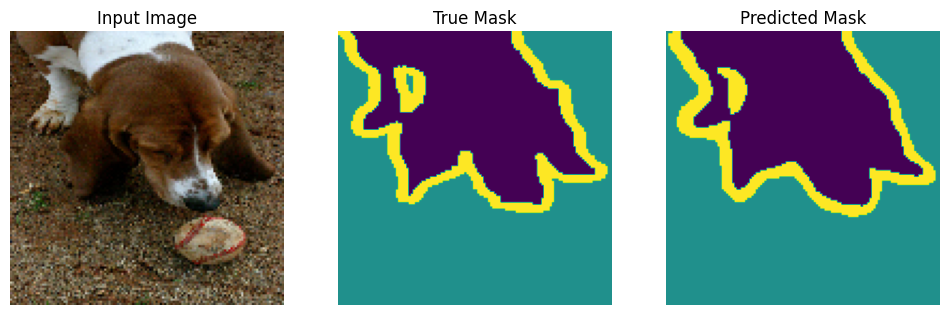


Sample Prediction after epoch 6

250/250 [==============================] - 64s 255ms/step - loss: 0.1426 - mean_io_u_1: 0.8585 - val_loss: 0.2174 - val_mean_io_u_1: 0.7833
Epoch 6: early stopping


In [ ]:
# Pre-train model
history_3a =model_3a.fit(X_train_p, 
            Y_train_cat,
            batch_size=25, 
            epochs=50,
            verbose=1,
            validation_data=(X_val_p,Y_val_cat),
            callbacks=callback_list)

dict_keys(['loss', 'mean_io_u_3', 'val_loss', 'val_mean_io_u_3'])


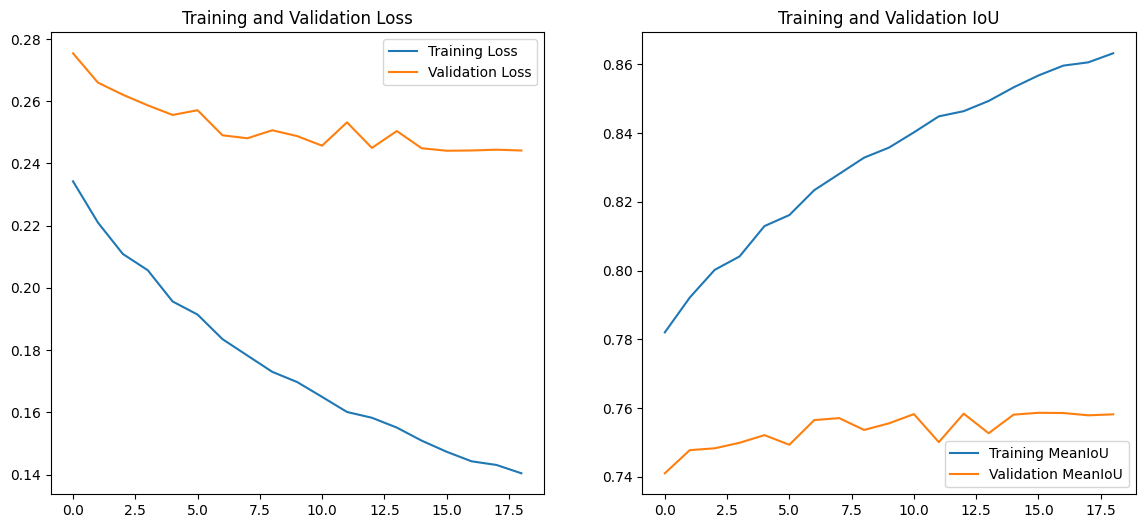

Training loss: 0.140	Training meanIoU: 0.863
Validation loss: 0.244	Validation meanIoU: 0.758


In [ ]:
show_history(history_3a)

In [ ]:
BACKBONE = 'resnext50'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_p = preprocess_input(X_train.copy())
X_val_p = preprocess_input(X_val.copy())
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_p = preprocess_input(X_train.copy())
X_val_p = preprocess_input(X_val.copy())

In [ ]:
# define model
activation='softmax'

model_4a = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                activation=activation,classes=n_classes,
                input_shape=(img_height,img_width,3),
                encoder_freeze=True)

current_model = model_4a

94428600/94428600 [==============================] - 3s 0us/step


1/1 [==============================] - 5s 5s/step


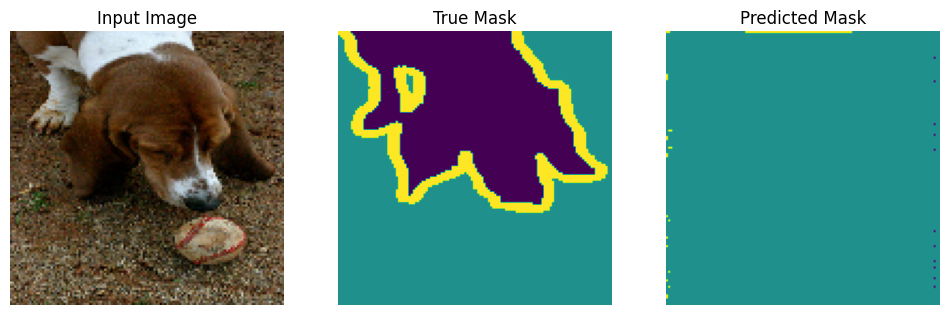

In [ ]:
show_predictions()

In [ ]:
#tf.keras.utils.plot_model(model_2a, show_shapes=True)
len(model_4a.layers)

1257

In [ ]:
LR = 0.0001
optimizer_input_4a = keras.optimizers.Adam(LR)
loss_input_4a = sm.losses.JaccardLoss()
metrics_input_4a = [tf.keras.metrics.MeanIoU(num_classes=3,
                                             sparse_y_pred = False,
                                             sparse_y_true=False)]

In [ ]:
model_4a.compile(optimizer=optimizer_input_4a,
              loss=loss_input_4a,
              metrics=metrics_input_4a)

1/1 [==============================] - 0s 54ms/step


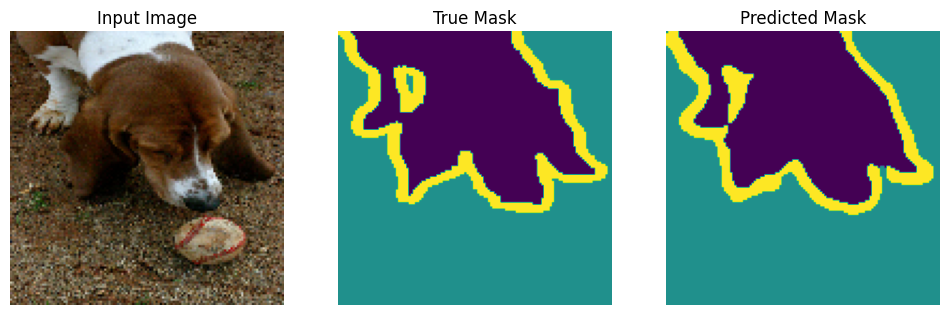


Sample Prediction after epoch 19

250/250 [==============================] - 63s 250ms/step - loss: 0.1525 - mean_io_u_2: 0.8488 - val_loss: 0.2142 - val_mean_io_u_2: 0.7868
Epoch 19: early stopping


In [ ]:
# Pre-train model
history_4a =model_4a.fit(X_train_p, 
            Y_train_cat,
            batch_size=25, 
            epochs=50,
            verbose=1,
            validation_data=(X_val_p,Y_val_cat),
            callbacks=callback_list)

In [ ]:
model_4a.trainable = True

1/1 [==============================] - 0s 51ms/step


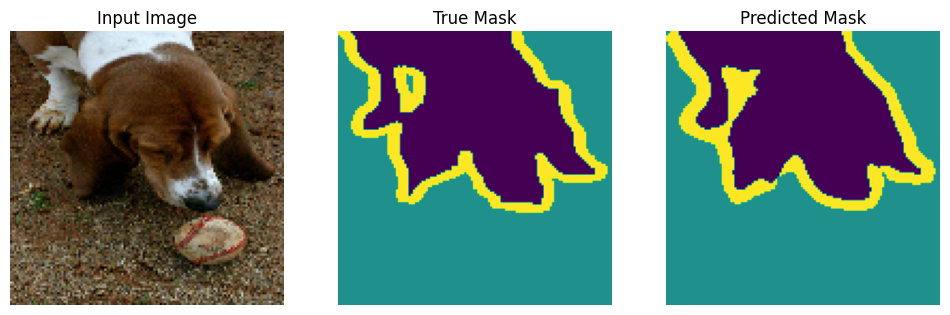


Sample Prediction after epoch 4

250/250 [==============================] - 62s 250ms/step - loss: 0.1445 - mean_io_u_2: 0.8568 - val_loss: 0.2134 - val_mean_io_u_2: 0.7876
Epoch 4: early stopping


In [ ]:
# Train model
history_4a =model_4a.fit(X_train_p, 
            Y_train_cat,
            batch_size=25, 
            epochs=50,
            verbose=1,
            validation_data=(X_val_p,Y_val_cat),
            callbacks=callback_list)

dict_keys(['loss', 'mean_io_u_2', 'val_loss', 'val_mean_io_u_2'])


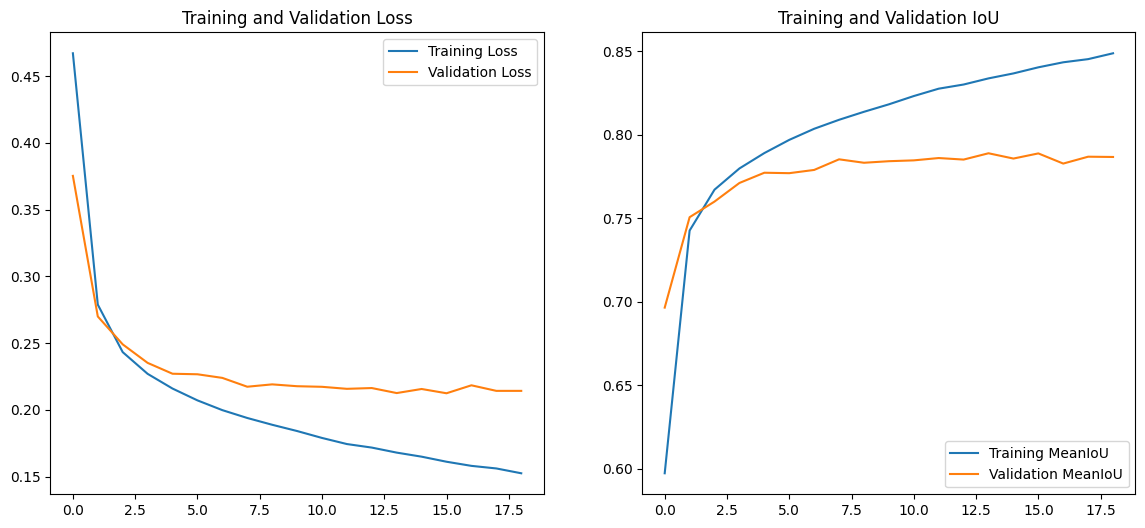

Training loss: 0.153	Training meanIoU: 0.849
Validation loss: 0.214	Validation meanIoU: 0.787


In [ ]:
show_history(history_4a)

In [25]:
BACKBONE = 'mobilenetv2'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_p = preprocess_input(X_train.copy())
X_val_p = preprocess_input(X_val.copy())
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_p = preprocess_input(X_train.copy())
X_val_p = preprocess_input(X_val.copy())

Image number: 4613


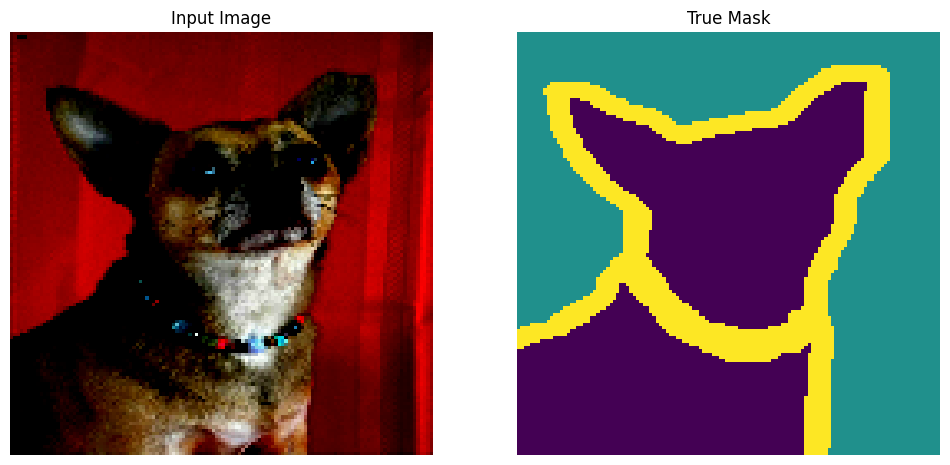

In [26]:
img_num = np.random.randint(0,len(X_train_p))
print(f'Image number: {img_num}')
sample_image, sample_mask = X_train_p[img_num],Y_train[img_num]
display([sample_image,sample_mask],divide=1)

In [ ]:
# define model
activation='softmax'

model_5a = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                activation=activation,classes=n_classes,
                input_shape=(img_height,img_width,3),
                encoder_freeze=True)

current_model = model_5a

1/1 [==============================] - 1s 1s/step


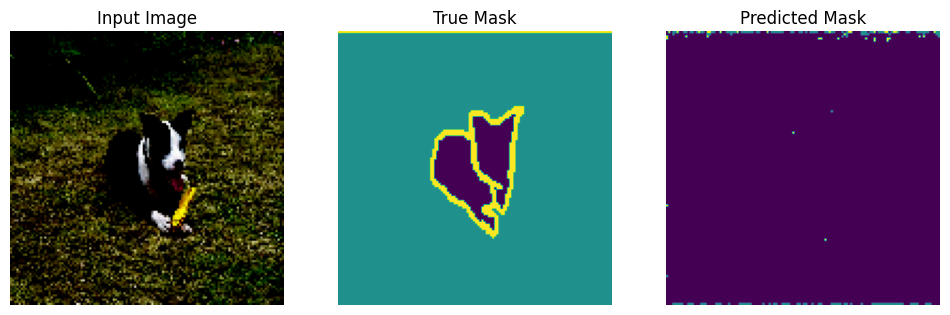

In [ ]:
show_predictions()

In [ ]:
#tf.keras.utils.plot_model(model_2a, show_shapes=True)
len(model_5a.layers)

196

In [ ]:
# try the method below where both LR and WD adjusted together
# see https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/AdamW
LR = 0.0001
#WD = 0.1

jaccard_loss = sm.losses.JaccardLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
categorical_loss = sm.losses.CategoricalCELoss()

total_loss = jaccard_loss + (1* focal_loss) + categorical_loss

optimizer_input_5a = keras.optimizers.Adam(learning_rate=LR)
loss_input_5a = total_loss
metrics_input_5a = [tf.keras.metrics.MeanIoU(num_classes=3,
                                             sparse_y_pred = False,
                                             sparse_y_true=False)]

In [ ]:
model_5a.compile(optimizer=optimizer_input_5a,
              loss=loss_input_5a,
              metrics=metrics_input_5a)

1/1 [==============================] - 0s 24ms/step


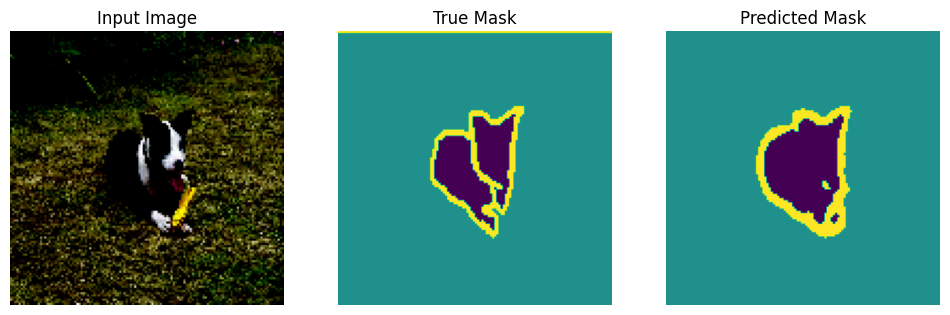


Sample Prediction after epoch 13

250/250 [==============================] - 24s 97ms/step - loss: 0.2362 - mean_io_u_14: 0.8420 - val_loss: 0.3445 - val_mean_io_u_14: 0.7828
Epoch 13: early stopping


In [ ]:
# Pre-train model
history_5a =model_5a.fit(X_train_p, 
            Y_train_cat,
            batch_size=25, 
            epochs=50,
            verbose=1,
            validation_data=(X_val_p,Y_val_cat),
            callbacks=callback_list)

In [ ]:
model_5a.trainable = True

1/1 [==============================] - 0s 21ms/step


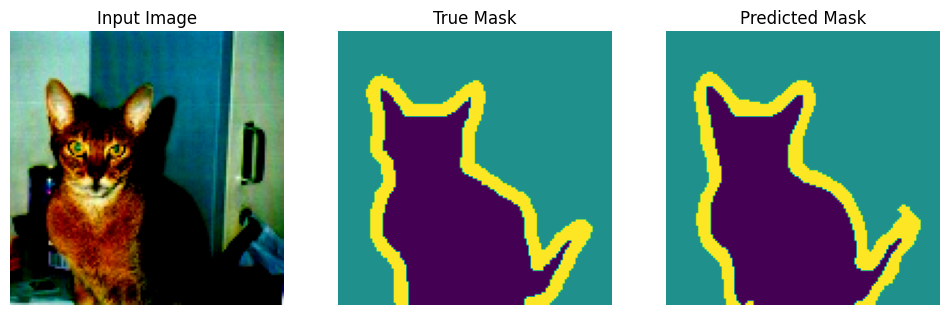


Sample Prediction after epoch 6

250/250 [==============================] - 23s 92ms/step - loss: 0.0493 - mean_io_u: 0.8563 - val_loss: 0.0731 - val_mean_io_u: 0.7860
Epoch 6: early stopping


In [ ]:
# Train model
history_5a =model_5a.fit(X_train_p, 
            Y_train_cat,
            batch_size=25, 
            epochs=50,
            verbose=1,
            validation_data=(X_val_p,Y_val_cat),
            callbacks=callback_list)

dict_keys(['loss', 'mean_io_u_14', 'val_loss', 'val_mean_io_u_14'])


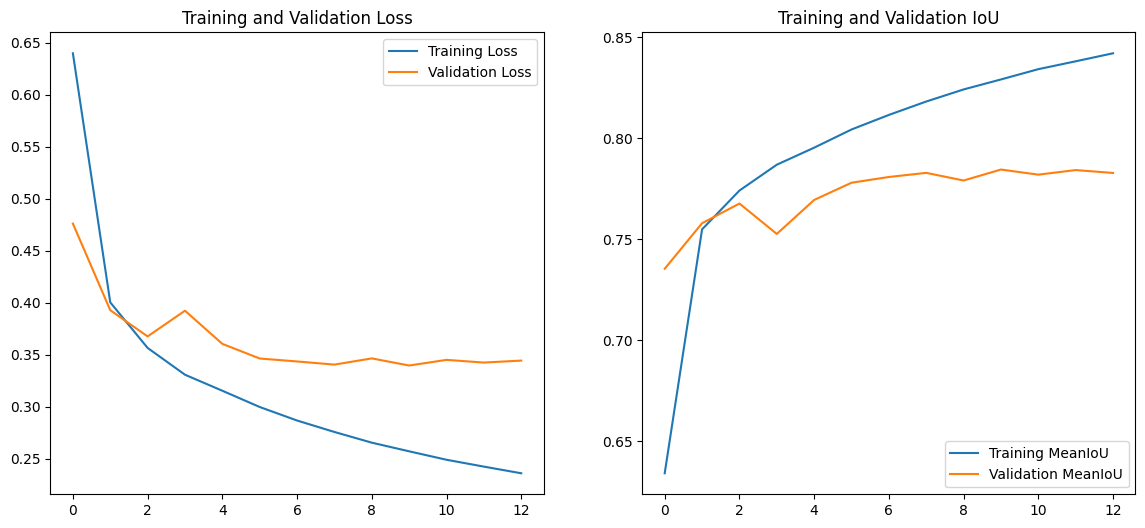

Training loss: 0.236	Training meanIoU: 0.842
Validation loss: 0.345	Validation meanIoU: 0.783


In [ ]:
show_history(history_5a)

In [ ]:
# define model
activation='softmax'

model_5b = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                activation=activation,classes=n_classes,
                input_shape=(img_height,img_width,3),
                encoder_freeze=True)

current_model = model_5b

1/1 [==============================] - 1s 908ms/step


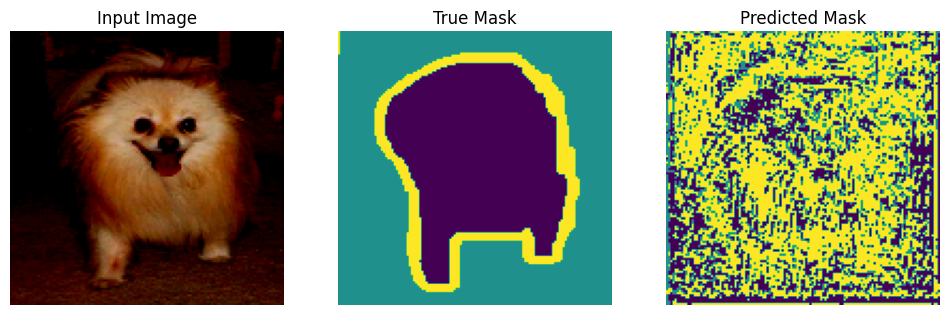

In [ ]:
show_predictions()

Optimizer = SGD<br>
--> learning rate = 0.001 : val MeanIOU = 0.674, val loss = 0.383, no overfitting (maybe slight underfitting)<br>
--> learning rate = 0.003 : val MeanIOU = 0.737, val loss = 0.305, very slight overfitting (less than 0.3%) on last 2 to 3 training epochs<br>
--> learning rate = 0.004 & momentum at 0.4: val meanIOU = 0.7515, val loss = 0.288, started to overfit at starting from epoch ~ 25 with gradual increase with overfiltting (at epoch 50, train mean IOU = 0.7653 - about 1.8% overfitting)<br>
--> learning rate = 0.006 & momentum at 0.6: val meanIOU = 0.767, val loss = 0.270, started to overfit at starting from epoch ~ 10 with gradual increase with overfiltting (at epoch 50, train mean IOU = 0.801 - about 4.4% overfitting)<br>
--> learning rate = 0.006 & momentum at 0.9: val meanIOU = 0.764, val loss = 0.273, started to overfit at starting from epoch ~ 3 or 4 with gradual increase with overfiltting (at epoch 23(early stopping), train mean IOU = 0.815 - about 6.7% overfitting)<br>
--> learning rate = 0.006 & momentum at 0.1:val meanIOU = 0.754, val loss = 0.285, started to overfit at starting from epoch ~ 20 with gradual increase with overfiltting (at epoch 50, train mean IOU = 0.771 - about 2.2% overfitting)
--> learning rate = 0.006 & momentum at 0 & weight decay at 0.1: val meanIOU = 0.1929 and val loss = 0.9107, train meanIOU about 0.56, early stopping epoch 4.
--> learning rate = 0.006 & momentum at 0 & weight decay at 0.9: val meanIOU = 0.1929 and val loss = 0.8514, train meanIOU about 0.1940, early stopping epoch 4.

In [ ]:

LR = 0.006
#WD = 0.1

jaccard_loss = sm.losses.JaccardLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
categorical_loss = sm.losses.CategoricalCELoss()

total_loss = jaccard_loss + (1* focal_loss) 

optimizer_input_5b = tf.optimizers.SGD(learning_rate=LR)
loss_input_5b = total_loss
metrics_input_5b = [tf.keras.metrics.MeanIoU(num_classes=3,
                                             sparse_y_pred = False,
                                             sparse_y_true=False)]

In [ ]:
model_5b.compile(optimizer=optimizer_input_5b,
              loss=loss_input_5b,
              metrics=metrics_input_5b)

1/1 [==============================] - 0s 22ms/step


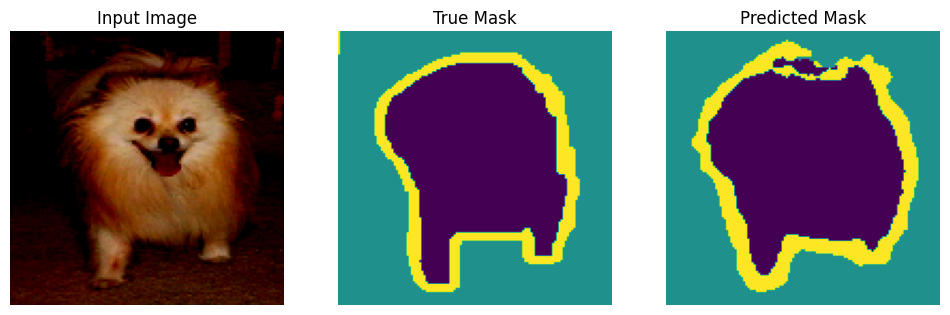


Sample Prediction after epoch 50

250/250 [==============================] - 23s 93ms/step - loss: 0.2704 - mean_io_u_9: 0.7655 - val_loss: 0.2878 - val_mean_io_u_9: 0.7516


In [ ]:
# Pre-train model
history_5b =model_5b.fit(X_train_p, 
            Y_train_cat,
            batch_size=25, 
            epochs=50,
            verbose=1,
            validation_data=(X_val_p,Y_val_cat),
            callbacks=callback_list)

dict_keys(['loss', 'mean_io_u_9', 'val_loss', 'val_mean_io_u_9'])


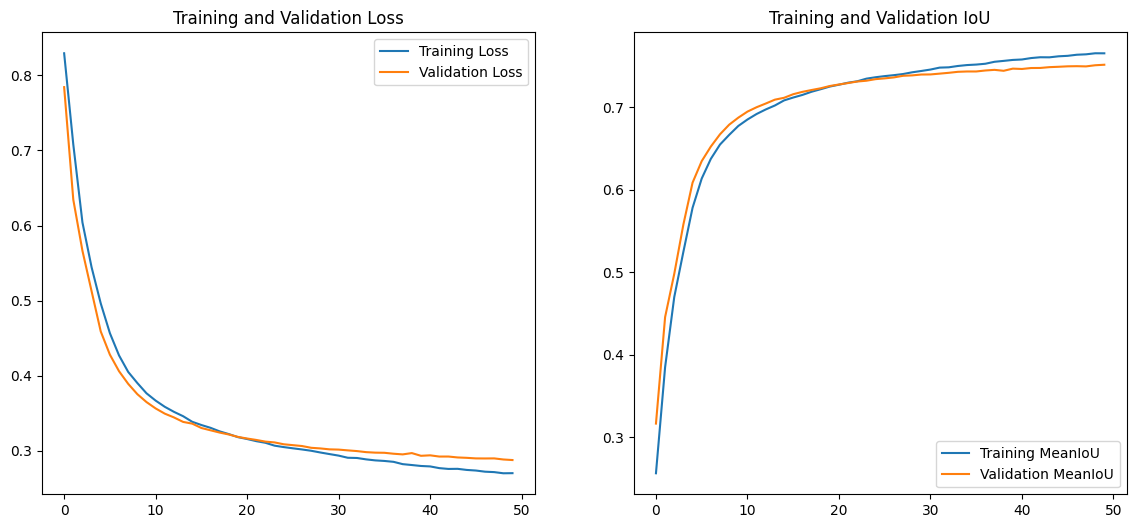

Training loss: 0.270	Training meanIoU: 0.765
Validation loss: 0.288	Validation meanIoU: 0.752


In [ ]:
show_history(history_5b)

In [ ]:
# define model
activation='softmax'

model_5b2 = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                activation=activation,classes=n_classes,
                input_shape=(img_height,img_width,3),
                encoder_freeze=True)

current_model = model_5b2

9406464/9406464 [==============================] - 0s 0us/step


1/1 [==============================] - 8s 8s/step


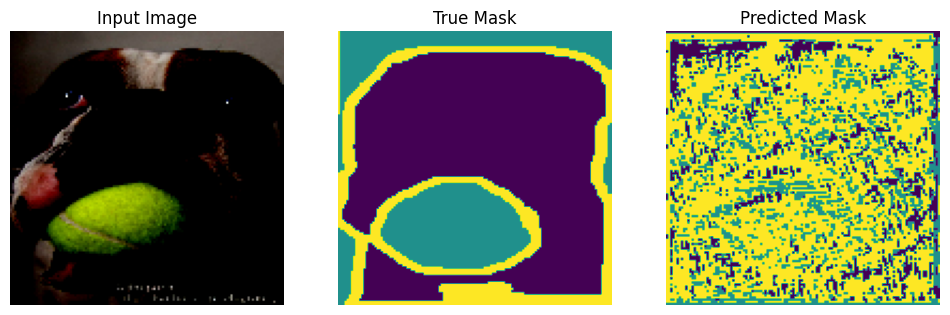

In [ ]:
show_predictions()

In [ ]:
#LR = 0.006


jaccard_loss = sm.losses.JaccardLoss()
focal_loss = sm.losses.CategoricalFocalLoss()

total_loss = jaccard_loss + (1* focal_loss) 


# use a learning rate that's 0.6 for the first 3750 steps, 0.3 for the next 3750 
# steps, and 0.001 for any additional steps
step = tf.Variable(0, trainable=False)
boundaries = [3750, 4000]
values = [0.006, 0.003, 0.001]
learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

# Later, whenever we perform an optimization step, we pass in the step.
learning_rate = learning_rate_fn(step)


optimizer_input_5b2 = tf.optimizers.SGD(learning_rate=learning_rate)
loss_input_5b2 = total_loss
metrics_input_5b2 = [tf.keras.metrics.MeanIoU(num_classes=3,
                                             sparse_y_pred = False,
                                             sparse_y_true=False)]

In [ ]:
model_5b2.compile(optimizer=optimizer_input_5b2,
              loss=loss_input_5b2,
              metrics=metrics_input_5b2)

1/1 [==============================] - 0s 23ms/step


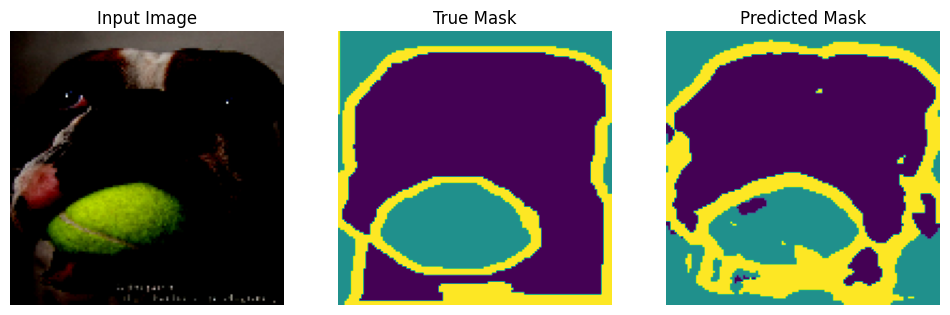


Sample Prediction after epoch 62

250/250 [==============================] - 23s 93ms/step - loss: 0.2581 - mean_io_u: 0.7757 - val_loss: 0.2841 - val_mean_io_u: 0.7548
Epoch 62: early stopping


In [ ]:
# Pre-train model
history_5b2 =model_5b2.fit(X_train_p, 
            Y_train_cat,
            batch_size=25, 
            epochs=75,
            verbose=1,
            validation_data=(X_val_p,Y_val_cat),
            callbacks=callback_list)

dict_keys(['loss', 'mean_io_u', 'val_loss', 'val_mean_io_u'])


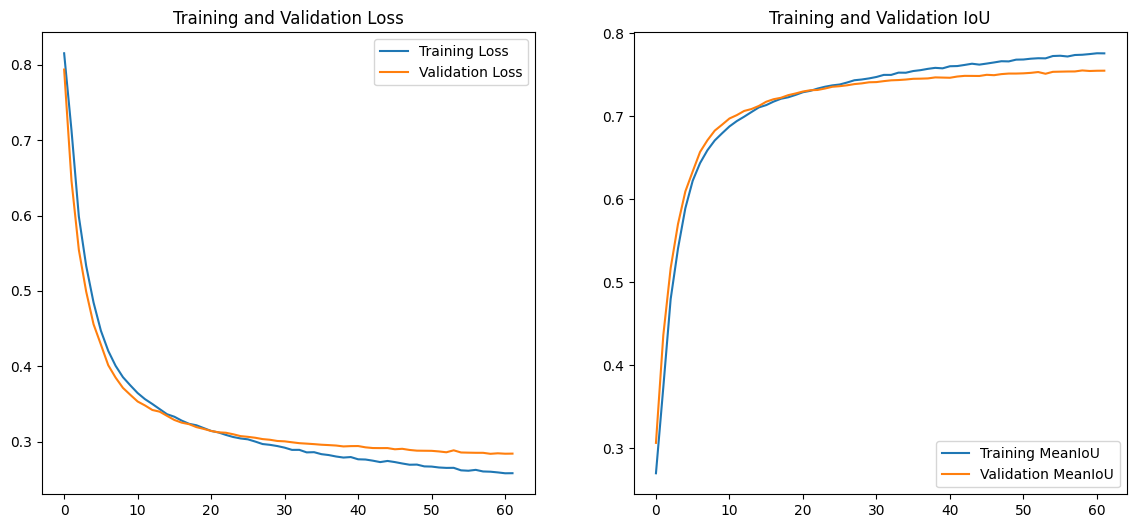

Training loss: 0.258	Training meanIoU: 0.776
Validation loss: 0.284	Validation meanIoU: 0.755


In [ ]:
show_history(history_5b2)

In [27]:
# define model
activation='softmax'

model_5b3 = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                activation=activation,classes=n_classes,
                input_shape=(img_height,img_width,3),
                encoder_freeze=True)

current_model = model_5b3

9406464/9406464 [==============================] - 0s 0us/step


1/1 [==============================] - 10s 10s/step


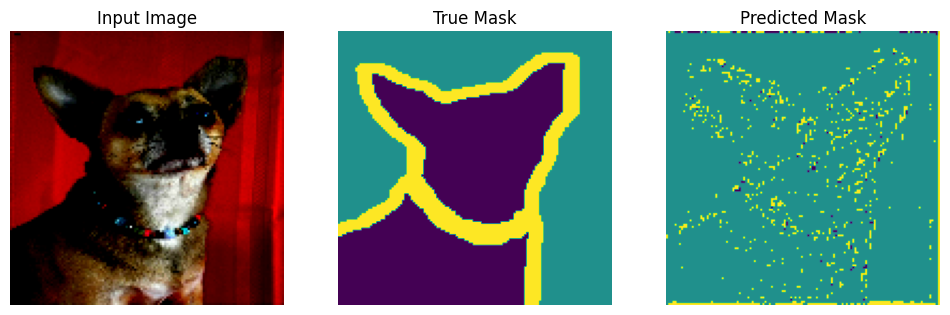

In [28]:
show_predictions()

In [30]:
LR = 0.006

jaccard_loss = sm.losses.JaccardLoss()
focal_loss = sm.losses.CategoricalFocalLoss()

total_loss = jaccard_loss + (1* focal_loss) 


optimizer_input_5b3 = tf.optimizers.SGD(learning_rate=LR)
loss_input_5b3 = total_loss
metrics_input_5b3 = [tf.keras.metrics.MeanIoU(num_classes=3,
                                             sparse_y_pred = False,
                                             sparse_y_true=False)]

In [31]:
#callback_list.pop()
callback_list

In [32]:
# This function keeps the initial learning rate for the first five epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
  if epoch <= 12:
    return lr
  elif epoch > 12 and epoch < 21:
    return 0.003
  else:
    return 0.001

lr_schedule_5b3 = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [33]:
if lr_schedule_5b3 not in callback_list: callback_list.append(lr_schedule_5b3)

In [34]:
callback_list

In [35]:
model_5b3.compile(optimizer=optimizer_input_5b3,
              loss=loss_input_5b3,
              metrics=[metrics_input_5b3])

1/1 [==============================] - 0s 25ms/step


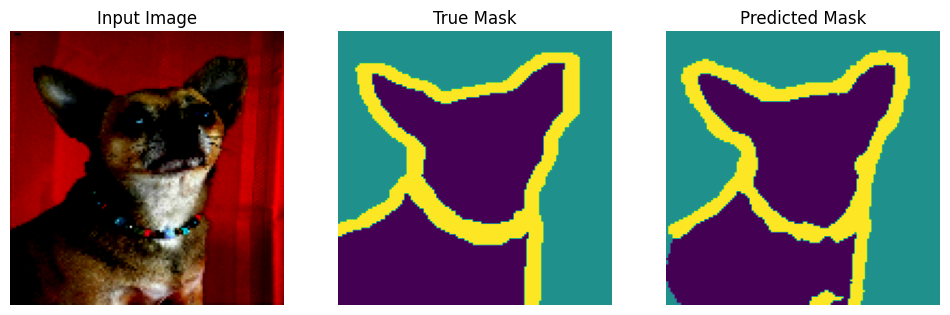


Sample Prediction after epoch 75

250/250 [==============================] - 24s 95ms/step - loss: 0.3002 - mean_io_u: 0.7403 - val_loss: 0.3096 - val_mean_io_u: 0.7336 - lr: 0.0010


In [36]:
# Pre-train model
history_5b3 =model_5b3.fit(X_train_p, 
            Y_train_cat,
            batch_size=25, 
            epochs=75,
            verbose=1,
            validation_data=(X_val_p,Y_val_cat),
            callbacks=callback_list)

dict_keys(['loss', 'mean_io_u', 'val_loss', 'val_mean_io_u', 'lr'])


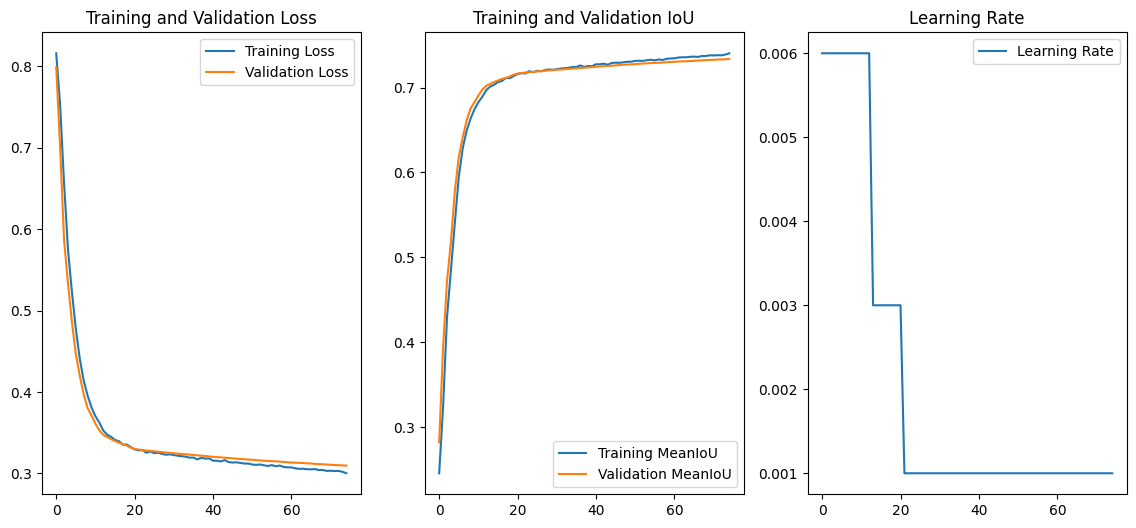

Training loss: 0.300	Training meanIoU: 0.740
Validation loss: 0.310	Validation meanIoU: 0.734


In [37]:
show_history(history_5b3)

In [ ]:
history_5b2.history.keys()

dict_keys(['loss', 'mean_io_u', 'val_loss', 'val_mean_io_u'])

In [69]:
# define model
activation='softmax'

model_5c = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                activation=activation,classes=n_classes,
                input_shape=(img_height,img_width,3),
                encoder_freeze=True)

current_model = model_5c

1/1 [==============================] - 1s 850ms/step


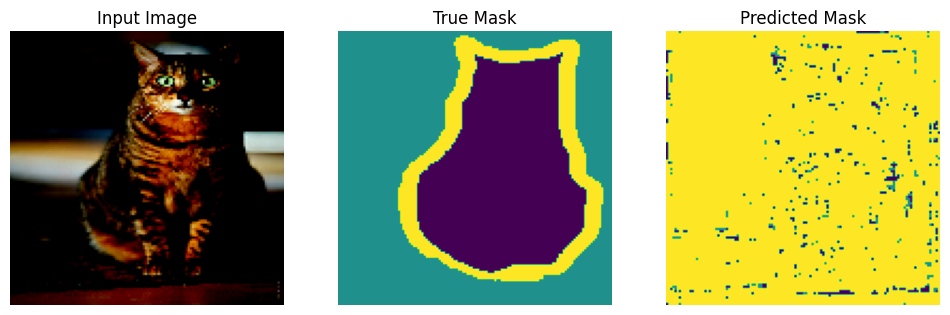

In [70]:
show_predictions()

In [71]:
# try the method below where both LR and WD adjusted together
# see https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/AdamW
#LR = 0.0001
#WD = 0.00001

#step = tf.Variable(0, trainable=False)
#schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
#    [10000, 15000], [1e-0, 1e-1, 1e-2])
# lr and wd can be a function or a tensor
#LR = 1e-4 * schedule(step)
#WD = lambda: 1e-6 * schedule(step)


#step = tf.Variable(0, trainable=False)
#boundaries = [750,800]
#values = [1e-5, 1e-6, 1e-7]
#learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
#    boundaries, values)

# Later, whenever we perform an optimization step, we pass in the step.
#LR = learning_rate_fn(step)


LR = 1e-5
jaccard_loss = sm.losses.JaccardLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
categorical_loss = sm.losses.CategoricalCELoss()

total_loss = jaccard_loss + (1* focal_loss) + categorical_loss

optimizer_input_5c = tf.optimizers.AdamW(learning_rate=LR)
loss_input_5c = total_loss
metrics_input_5c = [tf.keras.metrics.MeanIoU(num_classes=3,
                                             sparse_y_pred = False,
                                             sparse_y_true=False)]

In [72]:
callback_list.pop()
callback_list

In [73]:
# This function keeps the initial learning rate for the first five epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.6)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [68]:
2.71**-0.3

0.741496683230957

In [74]:
if lr_schedule not in callback_list: callback_list.append(lr_schedule)

In [75]:
callback_list

In [63]:
#def get_lr_metric(optimizer):
#    def lr(y_true, y_pred):
#        return optimizer.learning_rate # 
#    return lr

#lr_metric = get_lr_metric(optimizer_input_5c)




In [76]:
model_5c.compile(optimizer=optimizer_input_5c,
              loss=loss_input_5c,
              metrics=[metrics_input_5c])

1/1 [==============================] - 0s 22ms/step


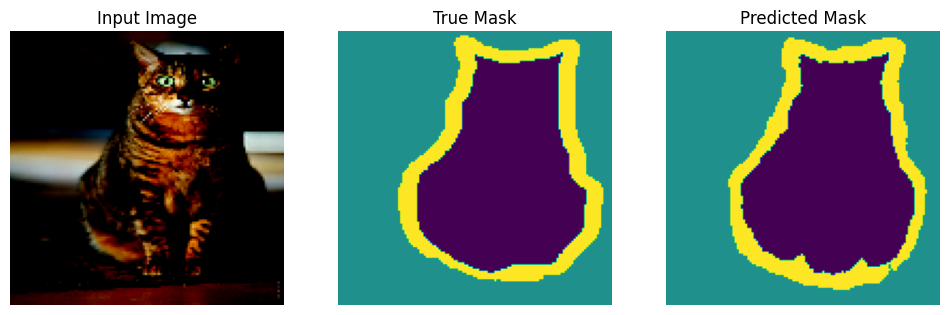


Sample Prediction after epoch 21

250/250 [==============================] - 25s 99ms/step - loss: 0.4393 - mean_io_u_2: 0.7504 - val_loss: 0.4471 - val_mean_io_u_2: 0.7463 - lr: 6.7729e-10
Epoch 21: early stopping


In [77]:
# Pre-train model
history_5c =model_5c.fit(X_train_p, 
            Y_train_cat,
            batch_size=25, 
            epochs=75,
            verbose=1,
            validation_data=(X_val_p,Y_val_cat),
            callbacks=callback_list)

dict_keys(['loss', 'mean_io_u_2', 'val_loss', 'val_mean_io_u_2', 'lr'])


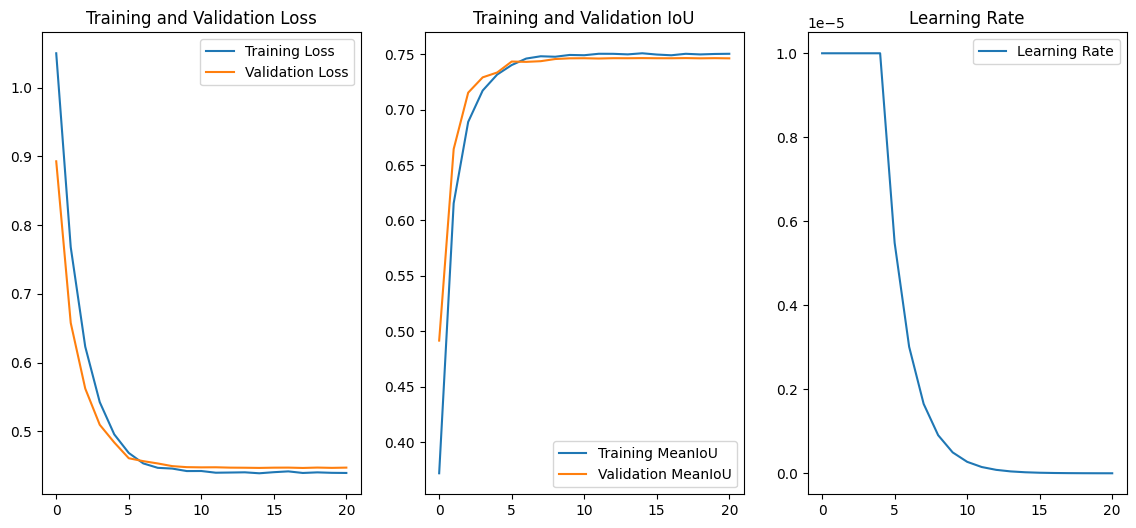

Training loss: 0.439	Training meanIoU: 0.750
Validation loss: 0.447	Validation meanIoU: 0.746


In [78]:
show_history(history_5c)

In [25]:
BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_p = preprocess_input(X_train.copy())
X_val_p = preprocess_input(X_val.copy())
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_p = preprocess_input(X_train.copy())
X_val_p = preprocess_input(X_val.copy())

Image number: 3841


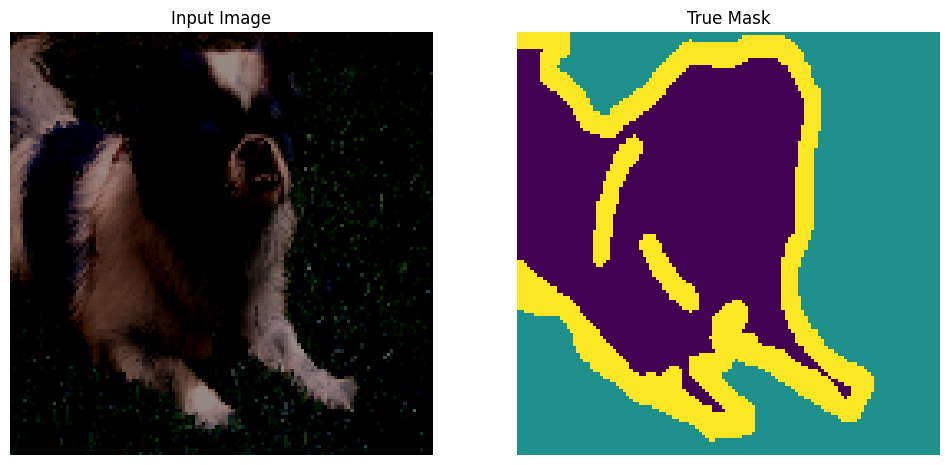

In [26]:
img_num = np.random.randint(0,len(X_train_p))
print(f'Image number: {img_num}')
sample_image, sample_mask = X_train_p[img_num],Y_train[img_num]
display([sample_image,sample_mask])

In [55]:
# define model
activation='softmax'

model_6a = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                activation=activation,classes=n_classes,
                input_shape=(img_height,img_width,3),
                encoder_freeze=True)

current_model = model_6a

1/1 [==============================] - 0s 319ms/step


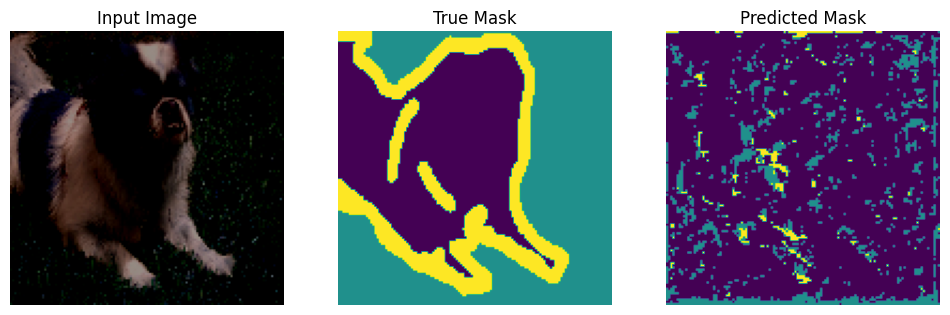

In [56]:
show_predictions()

In [57]:
LR = 1e-4
jaccard_loss = sm.losses.JaccardLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
categorical_loss = sm.losses.CategoricalCELoss()

total_loss = jaccard_loss + (1* focal_loss) + categorical_loss

optimizer_input_6a = tf.optimizers.AdamW(learning_rate=LR)
loss_input_6a = total_loss
metrics_input_6a = [tf.keras.metrics.MeanIoU(num_classes=3,
                                             sparse_y_pred = False,
                                             sparse_y_true=False)]

0.00015

In [58]:
callback_list.pop()
callback_list

In [59]:
# This function keeps the initial learning rate for the first five epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
  if epoch < 3:
    return lr
  else:
    return lr * 0.8
    #return lr * tf.math.exp(-0.3)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [60]:
if lr_schedule not in callback_list: callback_list.append(lr_schedule)

In [61]:
callback_list

In [62]:
model_6a.compile(optimizer=optimizer_input_6a,
              loss=loss_input_6a,
              metrics=[metrics_input_6a])

1/1 [==============================] - 0s 21ms/step


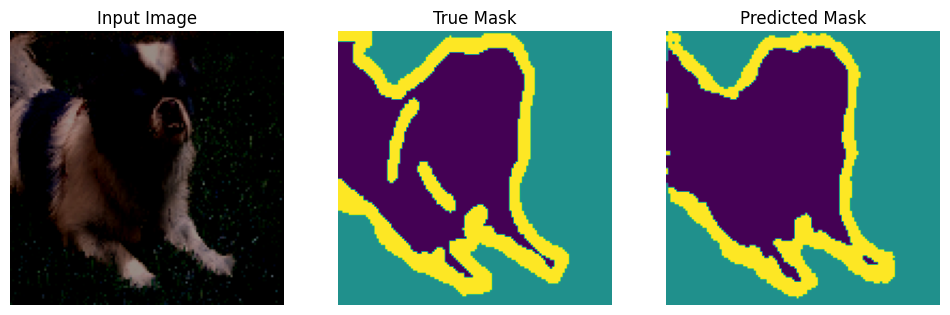


Sample Prediction after epoch 14

250/250 [==============================] - 29s 118ms/step - loss: 0.3289 - mean_io_u_3: 0.7858 - val_loss: 0.4056 - val_mean_io_u_3: 0.7473 - lr: 8.5899e-06
Epoch 14: early stopping


In [63]:
# Pre-train model
history_6a =model_6a.fit(X_train_p, 
            Y_train_cat,
            batch_size=25, 
            epochs=75,
            verbose=1,
            validation_data=(X_val_p,Y_val_cat),
            callbacks=callback_list)

dict_keys(['loss', 'mean_io_u_3', 'val_loss', 'val_mean_io_u_3', 'lr'])


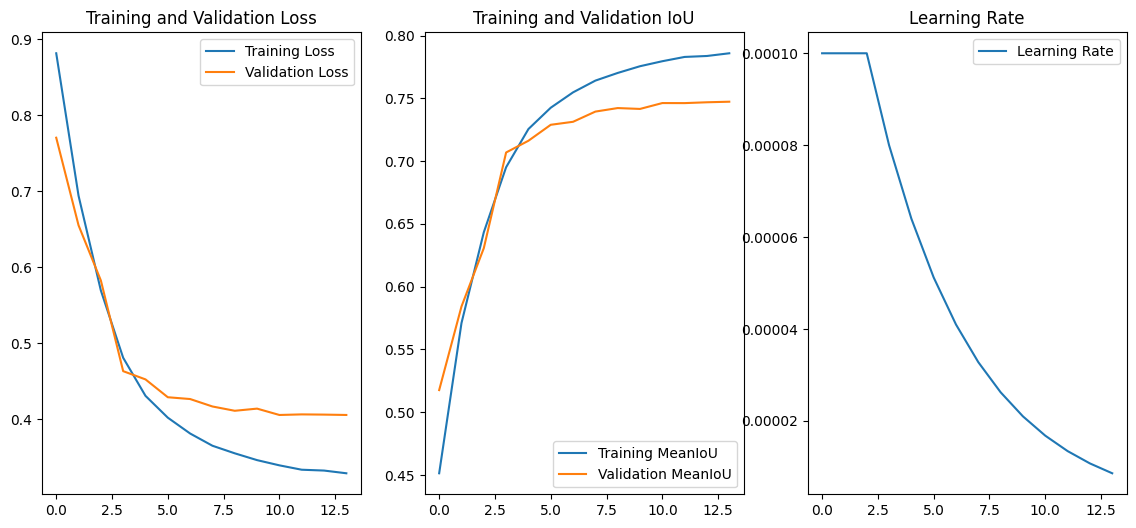

Training loss: 0.329	Training meanIoU: 0.786
Validation loss: 0.406	Validation meanIoU: 0.747


In [64]:
show_history(history_6a)

In [65]:
BACKBONE = 'efficientnetb0'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_p = preprocess_input(X_train.copy())
X_val_p = preprocess_input(X_val.copy())
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_p = preprocess_input(X_train.copy())
X_val_p = preprocess_input(X_val.copy())

Image number: 2465


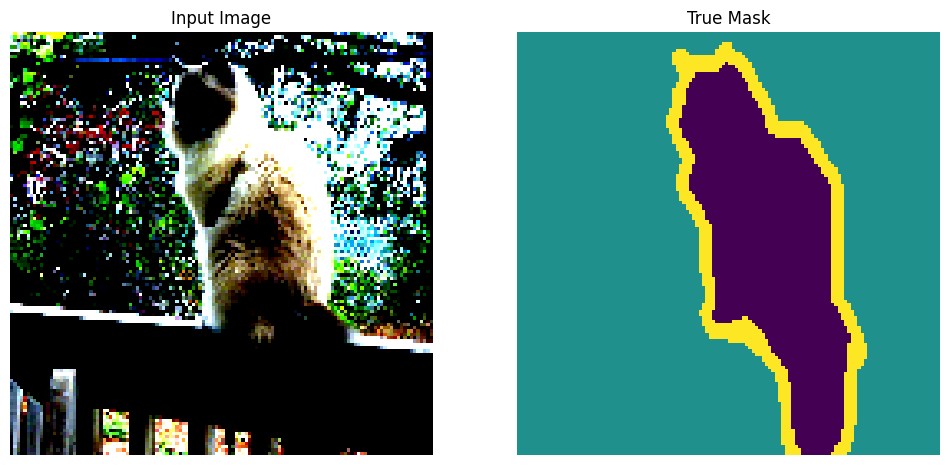

In [67]:
img_num = np.random.randint(0,len(X_train_p))
print(f'Image number: {img_num}')
sample_image, sample_mask = X_train_p[img_num],Y_train[img_num]
display([sample_image,sample_mask],divide=1)

In [81]:
# define model
activation='softmax'

model_7a = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                activation=activation,classes=n_classes,
                input_shape=(img_height,img_width,3),
                encoder_freeze=True)

current_model = model_7a

1/1 [==============================] - 1s 1s/step


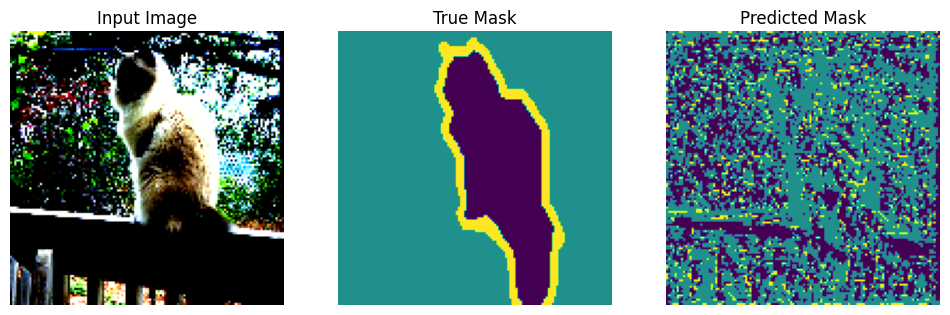

In [82]:
show_predictions()

In [83]:
LR = 1e-4
jaccard_loss = sm.losses.JaccardLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
categorical_loss = sm.losses.CategoricalCELoss()

total_loss = jaccard_loss + (1* focal_loss) + categorical_loss

optimizer_input_7a = tf.optimizers.AdamW(learning_rate=LR)
loss_input_7a = total_loss
metrics_input_7a = [tf.keras.metrics.MeanIoU(num_classes=3,
                                             sparse_y_pred = False,
                                             sparse_y_true=False)]

In [84]:
callback_list.pop()
callback_list

In [85]:
# This function keeps the initial learning rate for the first five epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
  if epoch < 3:
    return lr
  else:
    return lr * 0.5
    #return lr * tf.math.exp(-0.4)

lr_schedule_7a = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [86]:
if lr_schedule_7a not in callback_list: callback_list.append(lr_schedule_7a)

In [87]:
callback_list

In [88]:
model_7a.compile(optimizer=optimizer_input_7a,
              loss=loss_input_7a,
              metrics=[metrics_input_7a])

1/1 [==============================] - 0s 31ms/step


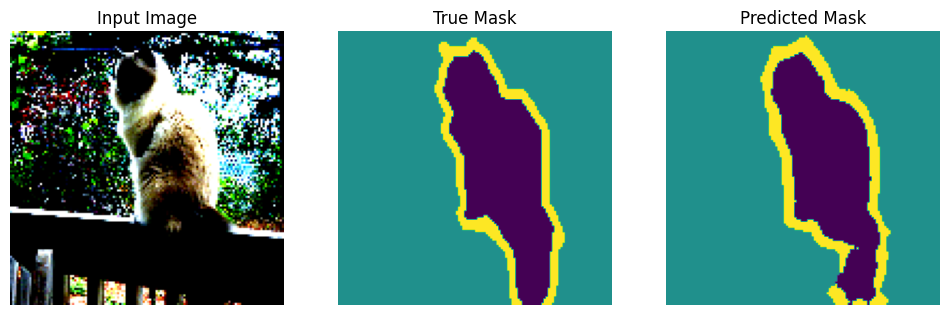


Sample Prediction after epoch 15

250/250 [==============================] - 35s 141ms/step - loss: 0.3039 - mean_io_u_5: 0.8023 - val_loss: 0.3477 - val_mean_io_u_5: 0.7781 - lr: 2.4414e-08
Epoch 15: early stopping


In [89]:
# Pre-train model
history_7a =model_7a.fit(X_train_p, 
            Y_train_cat,
            batch_size=25, 
            epochs=75,
            verbose=1,
            validation_data=(X_val_p,Y_val_cat),
            callbacks=callback_list)

dict_keys(['loss', 'mean_io_u_5', 'val_loss', 'val_mean_io_u_5', 'lr'])


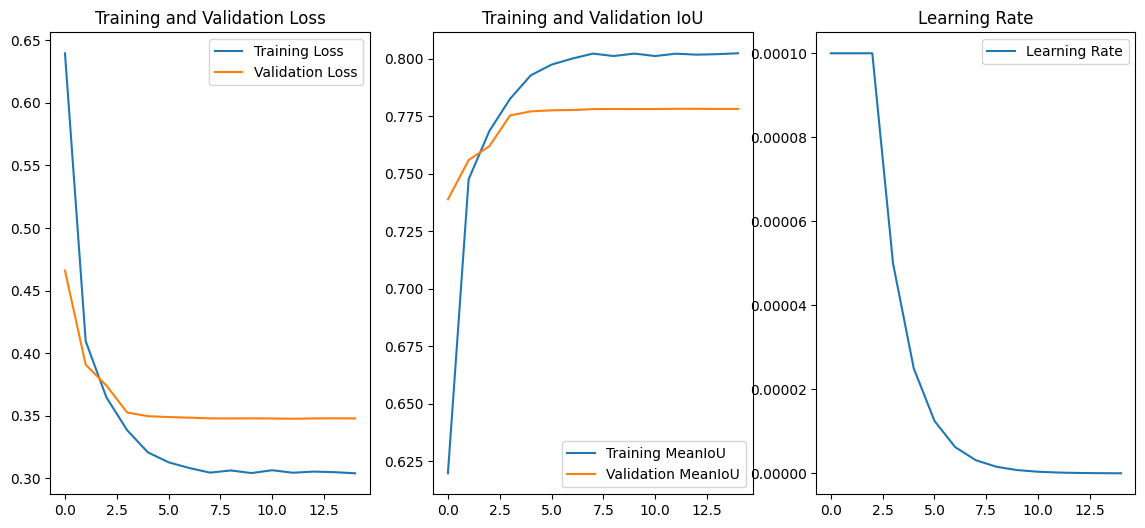

Training loss: 0.304	Training meanIoU: 0.802
Validation loss: 0.348	Validation meanIoU: 0.778


In [90]:
show_history(history_7a)

In [93]:
model_7a.trainable = True

In [94]:
model_7a.compile(optimizer=optimizer_input_7a,
              loss=loss_input_7a,
              metrics=[metrics_input_7a])

In [ ]:
# Pre-train model
history_7a =model_7a.fit(X_train_p, 
            Y_train_cat,
            batch_size=25, 
            epochs=75,
            verbose=1,
            validation_data=(X_val_p,Y_val_cat),
            callbacks=callback_list)